In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import torch
from sklearn.metrics import roc_auc_score,confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from transformers import pipeline
from scipy.special import softmax
import shap
from datasets import load_dataset
# Just get 1000 data points and only the text columns

/home/gwan/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-02 02:07:10.019664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 02:07:10.439340: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-02 02:07:10.601376: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable t

In [2]:
from sklearn.metrics import precision_recall_fscore_support

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
torch.version.cuda

'11.7'

In [4]:
sentences = train.sentence.values
sentences_test = test.sentence.values
y_test = test['labels']

## Transfomer based contextual embedding

In [18]:
tokenizer = AutoTokenizer.from_pretrained("TimKond/S-BioLinkBert-MedQuAD")

model = SentenceTransformer('TimKond/S-BioLinkBert-MedQuAD')

loading file https://huggingface.co/TimKond/S-BioLinkBert-MedQuAD/resolve/main/vocab.txt from cache at /home/gwan/.cache/huggingface/transformers/282ac2205c2b6ee055b3dc01c0a12028a0f7d7577410e4b0f4d645ac8ad5ae2e.73b5c069d3e40205dd2df2379051c9f47d13c3bad0bcb3cee659c69e3a185a86
loading file https://huggingface.co/TimKond/S-BioLinkBert-MedQuAD/resolve/main/tokenizer.json from cache at /home/gwan/.cache/huggingface/transformers/50f410f62d7dd7515615b2ca766bdad80a1849080838f4e92bdbf8b27e2c935f.e55b50961a3ab3d0999a4e5f18e565a07a5222dd3ad2ae9bee067fa0657a0eb0
loading file https://huggingface.co/TimKond/S-BioLinkBert-MedQuAD/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/TimKond/S-BioLinkBert-MedQuAD/resolve/main/special_tokens_map.json from cache at /home/gwan/.cache/huggingface/transformers/5296bd60fb8c7fb94768c904e58faadd292adc943980a00515ec55a19ce721bb.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/T

In [20]:
# Apprerantly Very simple embeddings clustering based on BERT does not tell anything about the sentiment
embeddings = model.encode(sentences)


In [21]:

embeddings_test = model.encode(sentences_test)

## 1: Machine learning based on embeddings

In [28]:
rf = RandomForestClassifier(class_weight={0:1,1:100},max_features=100,max_depth = 100)

rf.fit(X = embeddings,y = train['labels'])

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=100,
                       max_features=100)

In [29]:
rf_pred = rf.predict(embeddings_test)
rf_pred_prob = rf.predict_proba(embeddings_test)

In [30]:
from sklearn.metrics import accuracy_score


accuracy_score(y_test, rf_pred)

0.8275862068965517

In [31]:
precision_recall_fscore_support(y_test, rf_pred, average='binary')

(0.7142857142857143, 0.9090909090909091, 0.8, None)

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


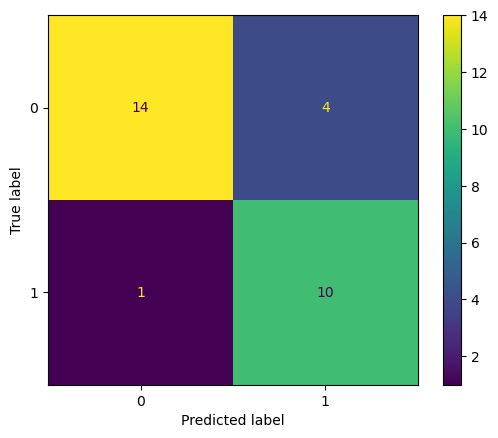

In [32]:
plot_confusion_matrix(rf,embeddings_test,y_test)

# 2: Pretrained Subjective BERT

In [33]:
classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
    return_all_scores=True,tokenizer="cffl/bert-base-styleclassification-subjective-neutral", max_length=512, truncation=True,
)

loading configuration file https://huggingface.co/cffl/bert-base-styleclassification-subjective-neutral/resolve/main/config.json from cache at /home/gwan/.cache/huggingface/transformers/bfd5c33143b50c6ac113ae1968fc7e425a16ce3742d162f9a62dfd88abf5f02f.e087ae233881216059233b1188427f7df0b885b85a39ed1731a2bcbac5c53f20
Model config BertConfig {
  "_name_or_path": "../models/TRIAL-J-shuffle-lr_3en06-epoch_15-wd_.1-bs_32/checkpoint-67466",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "SUBJECTIVE",
    "1": "NEUTRAL"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEUTRAL": "1",
    "SUBJECTIVE": "0"
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 

In [34]:
result_pretrained = classify(sentences_test.tolist())

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [35]:
bert1_pred_prob = np.zeros(test.shape[0])
for i,x in enumerate(result_pretrained):
    bert1_pred_prob[i] = x[1]['score']

In [36]:
accuracy_score(y_test,np.where(bert1_pred_prob > 0.5, 1, 0))

0.2413793103448276

In [37]:
precision_recall_fscore_support(y_test,np.where(bert1_pred_prob > 0.5, 1, 0), average='binary')

(0.07692307692307693, 0.09090909090909091, 0.08333333333333334, None)

# 3: Fine Tuned Model

In [5]:
data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset(path = './',data_files=data_files)

Using custom data configuration .-91eede86c7e1d8a6
Found cached dataset csv (/home/gwan/.cache/huggingface/datasets/csv/.-91eede86c7e1d8a6/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
100%|██████████| 2/2 [00:00<00:00, 474.04it/s]


In [6]:
task='sentiment'
MODEL = "cffl/bert-base-styleclassification-subjective-neutral"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
# tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [7]:
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, return_tensors="pt")

In [8]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Loading cached processed dataset at /home/gwan/.cache/huggingface/datasets/csv/.-91eede86c7e1d8a6/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-840d7e0249ecd91a.arrow
100%|██████████| 1/1 [00:00<00:00, 26.77ba/s]


In [9]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

Loading cached shuffled indices for dataset at /home/gwan/.cache/huggingface/datasets/csv/.-91eede86c7e1d8a6/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-58ac73cdc20c4cc7.arrow


In [10]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [12]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch",
weight_decay= 0.001,warmup_steps = 50, num_train_epochs=30,learning_rate = 1e-6,adam_epsilon = 1e-10)

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
trainer.train()# new result

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: index, sentence.
***** Running training *****
  Num examples = 113
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 450
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: wan19990901. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.161442,0.275862,0.160000,0.142857,0.181818
2,No log,1.090720,0.310345,0.285714,0.235294,0.363636
3,No log,0.989602,0.310345,0.333333,0.263158,0.454545
4,No log,0.893359,0.344828,0.387097,0.300000,0.545455
5,No log,0.821245,0.344828,0.387097,0.300000,0.545455
6,No log,0.766524,0.413793,0.451613,0.350000,0.636364
7,No log,0.721233,0.482759,0.482759,0.388889,0.636364
8,No log,0.677876,0.586207,0.571429,0.470588,0.727273
9,No log,0.642293,0.689655,0.666667,0.562500,0.818182
10,No log,0.620946,0.724138,0.714286,0.588235,0.909091


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: index, sentence.
***** Running Evaluation *****
  Num examples = 29
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: index, sentence.
***** Running Evaluation *****
  Num examples = 29
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: index, sentence.
***** Running Evaluation *****
  Num examples = 29
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: index, sentence.
***** Running Evaluation *****
  Num examples = 29
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding 

TrainOutput(global_step=450, training_loss=0.37148807101779513, metrics={'train_runtime': 194.6813, 'train_samples_per_second': 17.413, 'train_steps_per_second': 2.311, 'total_flos': 891946477670400.0, 'train_loss': 0.37148807101779513, 'epoch': 30.0})

In [13]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: annotation, id, text.
***** Running training *****
  Num examples = 425
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 540
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: wan19990901. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.606149,0.841121,0.105263,0.250000,0.066667
2,No log,0.436950,0.859813,0.000000,0.000000,0.000000
3,No log,0.409029,0.859813,0.000000,0.000000,0.000000
4,No log,0.477334,0.859813,0.000000,0.000000,0.000000
5,No log,0.352198,0.859813,0.000000,0.000000,0.000000
6,No log,0.365378,0.850467,0.428571,0.461538,0.400000
7,No log,0.495112,0.831776,0.526316,0.434783,0.666667
8,No log,0.542071,0.850467,0.428571,0.461538,0.400000
9,No log,0.663559,0.822430,0.457143,0.400000,0.533333
10,0.330700,0.651014,0.850467,0.428571,0.461538,0.400000


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: annotation, id, text.
***** Running Evaluation *****
  Num examples = 107
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: annotation, id, text.
***** Running Evaluation *****
  Num examples = 107
  Batch size = 8
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: annotation, id, text.
***** Running Evaluation *****
  Num examples = 107
  Batch size = 8
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior

TrainOutput(global_step=540, training_loss=0.3172623934569182, metrics={'train_runtime': 252.8155, 'train_samples_per_second': 16.811, 'train_steps_per_second': 2.136, 'total_flos': 1118221985280000.0, 'train_loss': 0.3172623934569182, 'epoch': 10.0})

In [ ]:
label[label.annotation == 1]

,id,text,annotation,label
1,1573658,ccu nursing progress note still feel alittle n...,1,1
4,1472567,sicu nsg note neuro ct scan head showed atroph...,1,1
7,561667,title chief complaint fever tachypnea hpi 73yo...,1,1
11,354817,altered mental status delirium assessment pati...,1,1
12,726477,87 female admitted er w resp distress family s...,1,1
...,...,...,...,...
519,2009786,progress note 7a 7p resp ra c e mild scr rr wn...,1,1
520,588510,title chief complaint dyspnea 24 hour events g...,1,1
523,42148,admission date 2118 8 10 discharge date 2118 8...,1,1
527,441775,chief complaint rigors 24 hour events 3 12 eve...,1,1


In [ ]:
label[label.annotation == 1]

,id,text,annotation,label
1,1573658,ccu nursing progress note still feel alittle n...,1,1
4,1472567,sicu nsg note neuro ct scan head showed atroph...,1,1
7,561667,title chief complaint fever tachypnea hpi 73yo...,1,1
11,354817,altered mental status delirium assessment pati...,1,1
12,726477,87 female admitted er w resp distress family s...,1,1
...,...,...,...,...
519,2009786,progress note 7a 7p resp ra c e mild scr rr wn...,1,1
520,588510,title chief complaint dyspnea 24 hour events g...,1,1
523,42148,admission date 2118 8 10 discharge date 2118 8...,1,1
527,441775,chief complaint rigors 24 hour events 3 12 eve...,1,1


In [ ]:
label[label.annotation == 1]

,id,text,annotation,label
1,1573658,ccu nursing progress note still feel alittle n...,1,1
4,1472567,sicu nsg note neuro ct scan head showed atroph...,1,1
7,561667,title chief complaint fever tachypnea hpi 73yo...,1,1
11,354817,altered mental status delirium assessment pati...,1,1
12,726477,87 female admitted er w resp distress family s...,1,1
...,...,...,...,...
519,2009786,progress note 7a 7p resp ra c e mild scr rr wn...,1,1
520,588510,title chief complaint dyspnea 24 hour events g...,1,1
523,42148,admission date 2118 8 10 discharge date 2118 8...,1,1
527,441775,chief complaint rigors 24 hour events 3 12 eve...,1,1


In [ ]:
label[label.annotation == 1]

,id,text,annotation,label
1,1573658,ccu nursing progress note still feel alittle n...,1,1
4,1472567,sicu nsg note neuro ct scan head showed atroph...,1,1
7,561667,title chief complaint fever tachypnea hpi 73yo...,1,1
11,354817,altered mental status delirium assessment pati...,1,1
12,726477,87 female admitted er w resp distress family s...,1,1
...,...,...,...,...
519,2009786,progress note 7a 7p resp ra c e mild scr rr wn...,1,1
520,588510,title chief complaint dyspnea 24 hour events g...,1,1
523,42148,admission date 2118 8 10 discharge date 2118 8...,1,1
527,441775,chief complaint rigors 24 hour events 3 12 eve...,1,1
